---
title: Naive Nerfs
date: 2023-08-09
subject: Neural Fields for SSH Interpolation
subtitle: Naive Nerfs applied to Images
short_title: Naive Nerfs - Images
authors:
  - name: J. Emmanuel Johnson
    affiliations:
      - CNRS
      - MEOM
    orcid: 0000-0002-6739-0053
    email: jemanjohnson34@gmail.com
license: CC-BY-4.0
keywords: data-assimilation, open-science
abbreviations:
    NerF: Neural Field
---

> Neural Fields (NerFs) are an emerging class of coordinate-based neural networks. There has been many developments in the last few years for applying NerFs to data like images. In this tutorial, I will introduce NerFs from the geoscience perspective and highlight some potential advantages to using these methods. I will demonstrate some concrete work on sea surface height interpolation and highlight some of the problems (and potential solutions) I faced when applying this class of methods to spatiotemporal data.

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"

import autoroot
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as jrandom
import optax
import numpy as np
import pandas as pd
import equinox as eqx
import xarray as xr
import keras_core as keras
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm, trange
from jaxtyping import Float, Array, PyTree, ArrayLike
import wandb
from dataclasses import dataclass
import hydra
from omegaconf import OmegaConf

sns.reset_defaults()
sns.set_context(context="talk", font_scale=0.7)
jax.config.update("jax_enable_x64", False)

%env XLA_PYTHON_CLIENT_PREALLOCATE=false

%matplotlib inline
%load_ext autoreload
%autoreload 2

Using JAX backend.
env: XLA_PYTHON_CLIENT_PREALLOCATE=false


## Coordinate-Based Models

$$
\mathbf{x}\in\mathbb{R}^D
$$

**Example I**: Time Series

$$
\begin{aligned}
\text{Input}: && t &\in \mathbb{R}^+ \\
\text{Outpit}: && f  &: \mathbb{R}\rightarrow\mathbb{R}^U
\end{aligned}
$$

**Example II:** Images

$$
x,y \in \mathbb{R}
$$

## Recap Formulation

We are interested in learning non-linear functions $\boldsymbol{f}$.

$$
\begin{aligned}
\boldsymbol{f}(\mathbf{x}) &=
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
\end{aligned}
$$

where the $\boldsymbol{\phi}(\cdot)$ is a basis function. Neural Fields typically try to learn this basis funciton via a series of composite functions of the form

$$
\boldsymbol{\phi}(\mathbf{x}) =
\boldsymbol{\phi}_L\circ\boldsymbol{\phi}_{L-1}
\circ\cdots\circ
\boldsymbol{\phi}_2\circ\boldsymbol{\phi}_{1}(\mathbf{x})
$$

## Problems

Here, we will demonstrate a problem that a naive network has.

## Data

In [2]:
from dataclasses import dataclass


@dataclass
class FoxDM:
    # _target_: str = "jejeqx._src.datamodules.image.ImageFox"
    _target_: str = "nerf4ssh._src.datamodules.image.ImageFox"
    batch_size: int = 10_000
    resize: int = 3
    shuffle: bool = False
    split_method: str = "even"
    # image_url: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/images/fox.jpg"
    # image_url: str = "/gpfswork/rech/cli/uvo53rl/projects/jejeqx/data/images/fox.jpg"


config_dm = OmegaConf.structured(FoxDM())

In [3]:
from nerf4ssh._src.datamodules.image import ImageFox

In [4]:
dm = hydra.utils.instantiate(config_dm)
dm.setup()


init = dm.ds_train[:32]
x_init, y_init = init

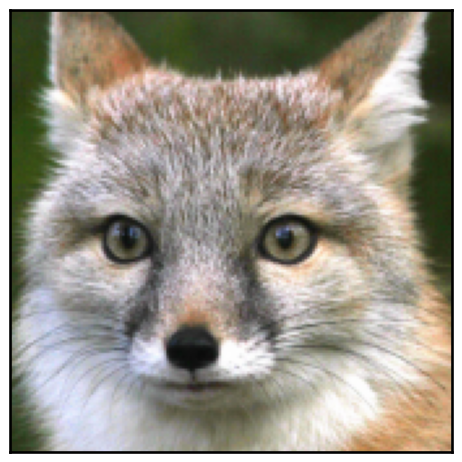

In [5]:
img = dm.load_image()
img.shape

fig, ax = plt.subplots()

ax.imshow(img)
ax.set(xticks=[], yticks=[])
plt.tight_layout()
# fig.savefig("./figures/demo/fox.png", dpi=100, transparent=True)
plt.show()

## Coordinates


$$
\vec{\mathbf{x}} = 
\begin{bmatrix}
x \\ y
\end{bmatrix}
$$

$$
\mathbf{y} =
\begin{bmatrix}
R \\ B \\ G
\end{bmatrix}
$$

In [6]:
print(f"Image Shape: {img.shape}")
print(f"Number of Coords: {len(dm.ds_train):,}")

Image Shape: (170, 170, 3)
Number of Coords: 14,450


## Model

The input data is a coordinate vector, $\mathbf{x}_\phi$, of the image coordinates.

$$
\mathbf{x}_\phi \in \mathbb{R}^{D_\phi}
$$

where $D_\phi = [\text{x}, \text{y}]$. So we are interested in learning a function, $\boldsymbol{f}$, such that we can input a coordinate vector and output a scaler/vector value of the pixel value.

$$
\mathbf{u} = \boldsymbol{f}(\mathbf{x}_\phi; \boldsymbol{\theta})
$$

### MLP Layer

$$
\mathbf{f}_\ell(\mathbf{x}) = \sigma\left(\mathbf{w}^{(\ell)}\mathbf{x} + \mathbf{b}^{(\ell)} \right)
$$

where $\sigma$ is the *ReLU* activation function.

$$
\sigma(\mathbf{x}) = \text{ReLU}(\mathbf{x})
$$

In [7]:
x_init.shape

torch.Size([32, 2])

In [15]:
from nerf4ssh._src.losses import psnr

In [9]:
input_shape = (2,)
model = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(units=128, activation="relu"),
        keras.layers.Dense(3, activation="sigmoid"),
    ]
)

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)               │        384 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_1 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_2 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_3 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_4 (Dense)                 │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_5 (Dense)                 │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,819 (261.01 KB)

 Trainable params: 66,819 (261.01 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
len(dm.ds_train)

14450

In [12]:
batch_size = 32
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-2
)

In [13]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [14]:

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_mlp_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=10),
]

In [15]:
# model.save("saved_models/final_model_mlp_.keras", )
# model = keras.saving.load_model("saved_models/final_model_mlp.keras")

In [16]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [17]:
history_mlp = model.fit(
    x=dm.train_dataloader(),
    validation_data=dm.val_dataloader(),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step - loss: 0.0604 - psnr: 14.9737 - val_loss: 0.0612 - val_psnr: 15.0214
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - loss: 0.0585 - psnr: 15.2043 - val_loss: 0.0541 - val_psnr: 15.7259
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - loss: 0.0534 - psnr: 15.9425 - val_loss: 0.0517 - val_psnr: 16.7390
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - loss: 0.0520 - psnr: 16.4418 - val_loss: 0.0502 - val_psnr: 16.0555
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0502 - psnr: 16.0408 - val_loss: 0.0470 - val_psnr: 16.6849
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - loss: 0.0481 - psnr: 16.5928 - val_loss: 0.0445 - val_psnr: 16.9324
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0450 - psnr: 16.9416 - val_loss: 0.0422 - val_psnr: 17.3480
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - loss: 0.0421 - psnr: 17.4100 - val_loss: 0.0386 - val_psnr: 17.7466
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━

In [18]:
# model.save("saved_models/final_model_mlp.keras")

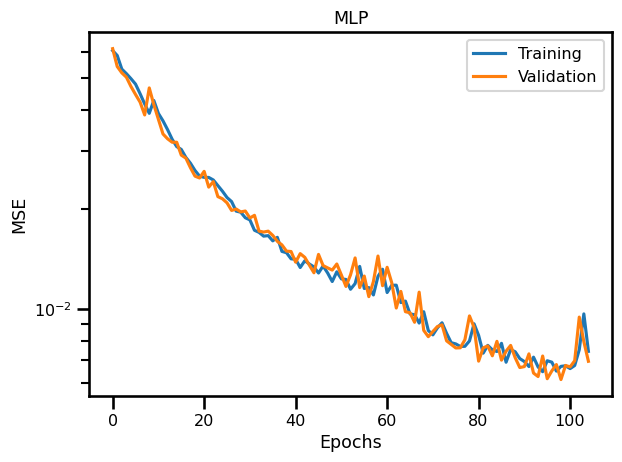

In [19]:
fig, ax = plt.subplots()

ax.plot(history_mlp.epoch, history_mlp.history['loss'], label="Training")
ax.plot(history_mlp.epoch, history_mlp.history['val_loss'], label="Validation")
ax.set(
    title="MLP",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
score = model.evaluate(x=dm.test_dataloader(), verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0073 - psnr: 26.4894


In [21]:
predictions = model.predict(x=dm.test_dataloader())

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


In [22]:
out_mlp = dm.coordinates_2_image(predictions)
out_mlp.shape

(170, 170, 3)

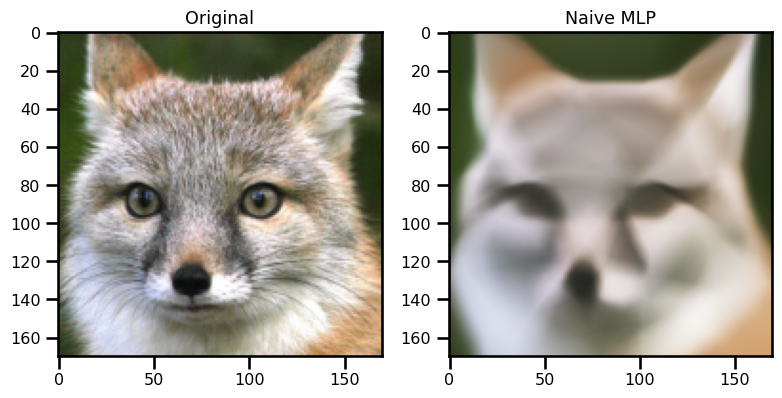

In [23]:
fig, ax = plt.subplots(ncols=2, figsize=(8, 4))
ax[0].imshow(img)
ax[0].set(title="Original")
ax[1].imshow(out_mlp)
ax[1].set(title="Naive MLP")

plt.tight_layout()
plt.show()

For this, we will use a simple adam optimizer with a `learning_rate` of 1e-4. From many studies, it appears that a lower learning rate works well with this methods because there is a lot of data. In addition, a bigger `batch_size` is also desireable. We will set the `num_epochs` to `2_000` which should be good enough for a single image. Obviously more epochs and a better learning rate scheduler would result in better results but this will be sufficient for this demo.

### Scheduler

<p align="center">
<img src="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png" alt="drawing" width="300"/>
<figcaption align = "center">
  <b>Fig.1 - An example for learning rate reduction when the validation loss stagnates. Source: 
    <a href="http://www.bdhammel.com/assets/learning-rate/resnet_loss.png">Blog</a>
  </b>
  </figcaption>
</p>

We will use a simple learning rate scheduler - `reduce_lr_on_plateau`. This will automatically reduce the learning rate as the validation loss stagnates. It will ensure that we really squeeze out as much performance as possible from our models during the training procedure.We start with a (relatively) high `learning_rate` of `1e-4` so we will set the `patience` to 5 epochs. So if there is no change in with every epoch, we decrease the learning rate by a factor of `0.1`.

This is a rather crude (but effective) method but it tends to work well in some situations. A better method might be the `cosine_annealing` method or the `exponential_decay` method. See other [examples](https://www.kaggle.com/code/snnclsr/learning-rate-schedulers/).


We are interested posterior of the parameters given the data. So we can use Bayes theorem to express this.

$$
p(\boldsymbol{\theta}|\mathcal{D}) \propto p(\mathcal{D}|\boldsymbol{\theta})p(\boldsymbol{\theta})
$$


This can be solved by using the maximimum likelihood method. So in this case, we need to define the likelihood term for the *data*. We can assume a Gaussian likelihood because we are working with continuous data. To make things simple, we can also assume a constant noise.

$$
p(y|\mathbf{x};\boldsymbol{\theta})=\mathcal{N}
\left(
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}), \sigma^2
\right)
$$

This is the *maximum likelihood estimation* problem. If we assume our samples are i.i.d., we get the following minimization problem

$$
\boldsymbol{\theta} = \underset{\boldsymbol{\theta}}{\text{argmin}}
\hspace{1mm} \sum_{y,\mathbf{x}\in\mathcal{D}}-\log p(y|\mathbf{x};\boldsymbol{\theta})
$$

Notice the slight of hand: the minimization of the negative log-likelihood is the same as the maxmimization of the log likelihood.

 If we assume a noise level of 1, i.e. $\sigma=1$, then this loss reduces to the *mean squared error* (MSE) loss function:

$$
\mathcal{L}(\boldsymbol{\theta}) = 
\frac{1}{|\mathcal{D}|} \sum_{n\in\mathcal{D}}
\left(y - \boldsymbol{f_\theta}(\mathbf{x})\right)^2
$$

We can take minibatches

$$
\mathcal{B}=\left\{\mathbf{x}_b,y_b \right\}^B_{b=1}
$$

which is a proper subset of the dataset, $\mathcal{B} \mathcal{D}=\mathcal{B}$.

So our new loss function will be:

$$
\mathcal{L}(\boldsymbol{\theta}) = 
\frac{1}{|\mathcal{B}|} \sum_{n\in\mathcal{B}}
\left(y - \boldsymbol{f_\theta}(\mathbf{x})\right)^2
$$

## Trainer Module

### Random Fourier Features

$$
\boldsymbol{\phi}(\mathbf{x}) = 
\sqrt{\frac{\sigma^2}{N_{RF}}}
\left[
\cos(\boldsymbol{\Omega}\mathbf{x}),
\sin(\boldsymbol{\Omega}\mathbf{x})
\right]
$$

where $\boldsymbol{\Omega}$ is a random matrix sampled from a Gaussian distribution.

$$
\begin{aligned}
p(\Omega)&\sim\mathcal{N}(0,\boldsymbol{\Lambda}^{-1}_D) \\
\boldsymbol{\Lambda}_D &= \text{diag}
\left(\lambda_1, \lambda_2, \ldots, \lambda_D\right)
\end{aligned}
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [238]:
from nerf4ssh._src.models.rff import RFFLayer

In [239]:
keras.initializers.constant()

In [240]:
input_shape = (2,)
model_rff = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        RFFLayer(num_features=256, length_scale_train=False),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=128, activation="swish"),
        keras.layers.Dense(units=3, activation="sigmoid"),
    ]
)

In [241]:
out = model_rff(x_init)

In [242]:
# model_rff = keras.saving.load_model("saved_models/final_model_rff.keras")

In [243]:
2/10

0.2

In [244]:
batch_size = 4_096
epochs = 1_000
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-5, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-3
)

# learning_rate = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-3, 
#     decay_steps=epochs - warmup_steps, 
#     decay_rate=0.01,
# )

In [245]:
model_rff.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [246]:

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_rff_image_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [247]:
history_rff = model_rff.fit(
    x=dm.train_dataloader(),
    validation_data=dm.val_dataloader(),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 1s/step - loss: 0.0606 - psnr: 15.0299 - val_loss: 0.0633 - val_psnr: 14.9172
Epoch 2/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step - loss: 0.0605 - psnr: 15.0509 - val_loss: 0.0629 - val_psnr: 14.9623
Epoch 3/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0601 - psnr: 15.1068 - val_loss: 0.0621 - val_psnr: 15.0471
Epoch 4/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - loss: 0.0595 - psnr: 15.2047 - val_loss: 0.0609 - val_psnr: 15.1799
Epoch 5/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0584 - psnr: 15.3570 - val_loss: 0.0588 - val_psnr: 15.4033
Epoch 6/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.0568 - psnr: 15.6101 - val_loss: 0.0558 - val_psnr: 15.7557
Epoch 7/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - loss: 0.0547 - psnr: 15.9622 - val_loss: 0.0528 - val_psnr: 16.1642
Epoch 8/1000
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.0531 - psnr: 16.2822 - val_loss: 0.0516 - val_psnr: 16.4068
Epoch 9/1000
2/2 ━━━━━━━━━━

KeyboardInterrupt: 

In [226]:
# model_rff.save("saved_models/final_model_rff.keras", )

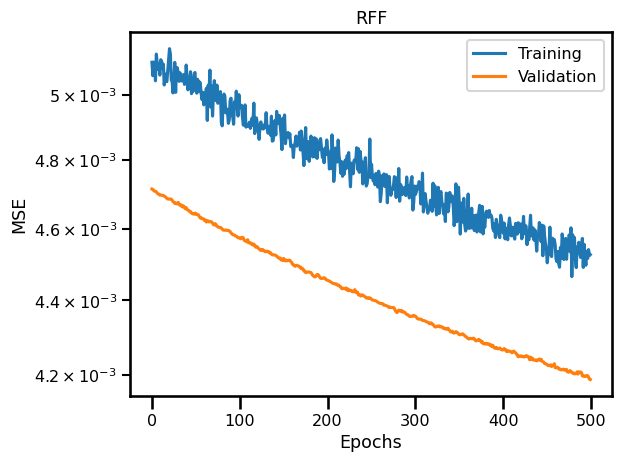

In [227]:
fig, ax = plt.subplots()

ax.plot(history_rff.epoch, history_rff.history['loss'], label="Training")
ax.plot(history_rff.epoch, history_rff.history['val_loss'], label="Validation")
ax.set(
    title="RFF",
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [228]:
score = model_rff.evaluate(x=dm.test_dataloader(), verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0046 - psnr: 28.3950


In [229]:
predictions = model_rff.predict(x=dm.test_dataloader())

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step


In [230]:
out_rff = dm.coordinates_2_image(predictions)
out_rff.shape

(170, 170, 3)

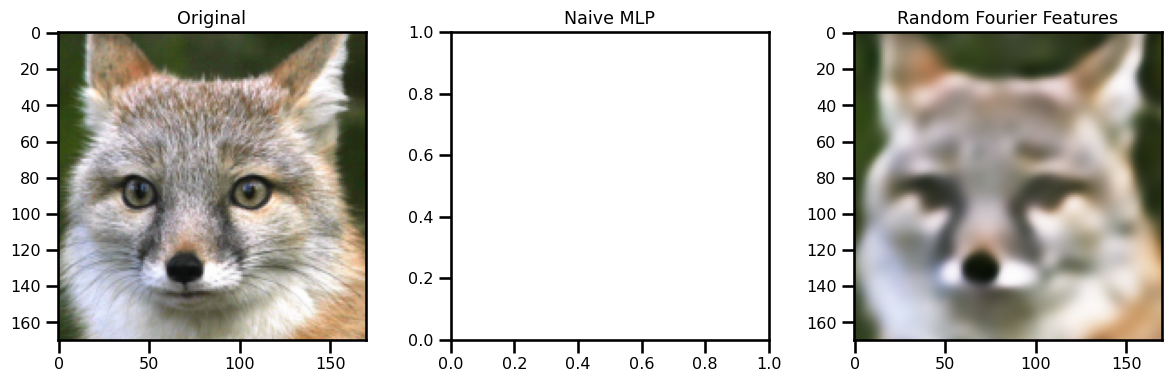

In [231]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))
ax[0].imshow(img)
ax[0].set(title="Original")
# ax[1].imshow(out_mlp)
ax[1].set(title="Naive MLP")
ax[2].imshow(out_rff)
ax[2].set(title="Random Fourier Features")

plt.tight_layout()
plt.show()

## Custom Activation Functions


**SIREN**

One of the most famous methods is the SIREN method. This replaces the standard activation function, $\sigma$, with a sinusoidal function.

$$
\phi(\mathbf{x})_\ell = \sin 
\left( \omega_\ell\left( 
\mathbf{w}_\ell\mathbf{x} + \mathbf{b}_\ell
\right)\right)
$$

So our final neural network with the additional basis function:

$$
\boldsymbol{f}(\mathbf{x};\boldsymbol{\theta}) =
\mathbf{w}^\top\boldsymbol{\phi}(\mathbf{x})+\mathbf{b}
$$

where $\boldsymbol{\phi}(\cdot)$ is the learned *basis network*.

In [90]:
from nerf4ssh._src.models.siren import SirenLayer, SineInitializers

In [91]:
input_shape = (2,)
c = 6
omega_0 = 30
omega = 1.0
model_siren = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        SirenLayer(units=128, omega=omega_0, c=c, layer_type="first"),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        SirenLayer(units=128, omega=omega, c=c),
        keras.layers.Dense(units=3, kernel_initializer=SineInitializers(c=c, omega=omega, layer_type="last"), activation="sigmoid"),
        # SirenLayer(units=3, omega=omega, c=c, layer_type="last"),
    ]
)

In [92]:
model_siren.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ siren_layer_5 (SirenLayer)      │ (None, 128)               │        384 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_6 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_7 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_8 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ siren_layer_9 (SirenLayer)      │ (None, 128)               │     16,512 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ dense_31 (Dense)                │ (None, 3)                 │        387 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 66,819 (261.01 KB)

 Trainable params: 66,819 (261.01 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
# model_siren = keras.saving.load_model("saved_models/final_model_siren.keras")

In [94]:
batch_size = 10_000
epochs = 500
warmup_steps = 10
learning_rate = keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=1e-4, 
    decay_steps=epochs - warmup_steps, 
    alpha=0.1, 
    warmup_steps=warmup_steps,
    warmup_target=1e-2
)

In [95]:
model_siren.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=[
        psnr,
    ]
)

In [96]:
len(dm.ds_train)

14450

In [97]:
# batch_size = 30_000
# epochs = 250
# verbose = 0

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="./checkpoints/model_siren_fox_at_epoch_{epoch}.keras", save_best_only=True),
    keras.callbacks.EarlyStopping(monitor="loss", patience=50),
]

In [98]:
history_siren = model_siren.fit(
    x=dm.train_dataloader(),
    validation_data=dm.val_dataloader(),
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 755ms/step - loss: 0.0963 - psnr: 11.8648 - val_loss: 0.0720 - val_psnr: 13.2821
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0607 - psnr: 14.2631 - val_loss: 0.0296 - val_psnr: 17.7658
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - loss: 0.0295 - psnr: 17.7738 - val_loss: 0.0228 - val_psnr: 19.0360
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0217 - psnr: 19.3102 - val_loss: 0.0180 - val_psnr: 19.9740
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - loss: 0.0174 - psnr: 20.2185 - val_loss: 0.0147 - val_psnr: 20.9679
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - loss: 0.0144 - psnr: 21.0535 - val_loss: 0.0121 - val_psnr: 21.8901
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - loss: 0.0119 - psnr: 21.9382 - val_loss: 0.0101 - val_psnr: 22.5627
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - loss: 0.0100 - psnr: 22.6487 - val_loss: 0.0081 - val_psnr: 23.6378
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━

In [99]:
model_siren.save("saved_models/final_model_siren.keras")

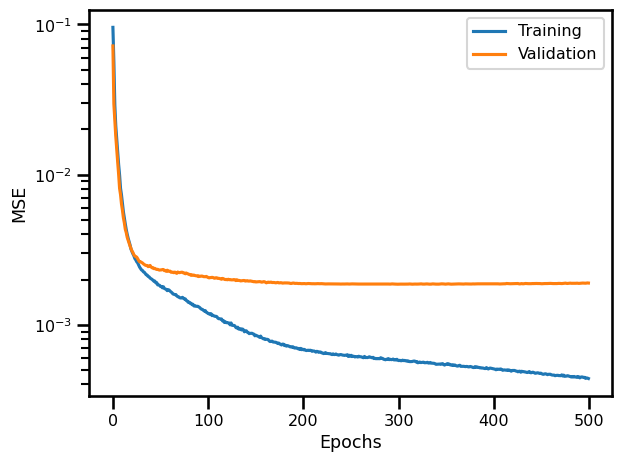

In [100]:
fig, ax = plt.subplots()

ax.plot(history_siren.epoch, history_siren.history['loss'], label="Training")
ax.plot(history_siren.epoch, history_siren.history['val_loss'], label="Validation")
ax.set(
    xlabel="Epochs", #xscale="log", 
    ylabel="MSE", yscale="log")
plt.legend()
plt.tight_layout()
plt.show()

In [101]:
score = model_siren.evaluate(x=dm.test_dataloader(), verbose=1)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 0.0015 - psnr: 34.8428


In [102]:
predictions = model_siren.predict(x=dm.test_dataloader())

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


In [103]:
out_siren = dm.coordinates_2_image(predictions)

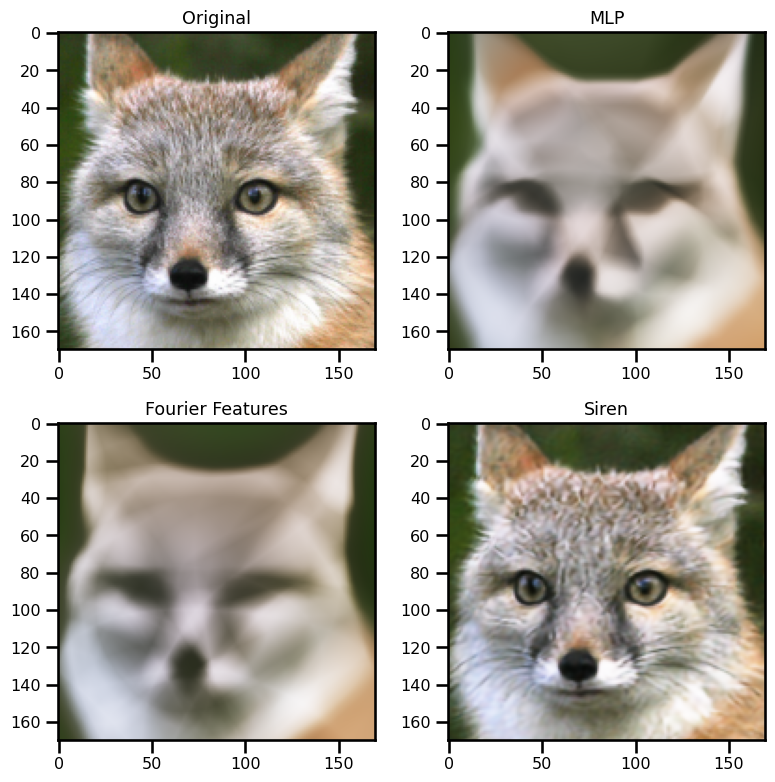

In [104]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 8))

ax[0, 0].imshow(img)
ax[0, 0].set(title="Original")
ax[0, 1].imshow(out_mlp)
ax[0, 1].set(title="MLP")
ax[1, 0].imshow(out_rff)
ax[1, 0].set(title="Fourier Features")
ax[1, 1].imshow(out_siren)
ax[1, 1].set(title="Siren")

plt.tight_layout()
plt.show()

In [181]:
# fig, ax = plt.subplots()

# ax.imshow(out_siren)
# ax.set(xticks=[], yticks=[])
# plt.tight_layout()
# fig.savefig("./figures/demo/siren.png", dpi=100, transparent=True)
# plt.close()